<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper in Journal of Coastal and Hydraulic Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Analyses described in section 5 of the paper

#### Packages

In [22]:
# General packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
import sigfig as sf
import scipy.stats as stat

import hvec_stat.general_fit as gf
import hvec_stat.plotting as stplot
import hvec_stat.goodness_of_fit as gof
import hvec_stat.support as sup
import models as mdl
import utils as prj

In [23]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

In [24]:
tiny = 1e-12

In [25]:
bnd_lo = [-np.inf, -np.inf,          0,       0, -np.inf, -np.inf, -np.inf, -np.inf]
bnd_up = [ np.inf,  np.inf,     np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [26]:
df = prj.read_data_rws(constit_set = 'Ftested3')

In [27]:
df = df.loc[df['year'] >= 1945]

#### Calibrate per model

In [28]:
param = pd.DataFrame(columns = [
    'name',
    'var',
    'model',
    'intercept',
    'slope',
    '90%_band',
    'acceleration',
    'jerk',
    'A_885',
    'A_1861',
    'Rsqadj'], dtype = float)

In [29]:
vars = ['z0']

In [30]:
names = df['naam'].unique()

In [31]:
tprescr_lo = 1970
tprescr_up = 2005

In [32]:
# Full model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.model6,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]))

        p = res[0]

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Model 6')
        intercept.append(p[0])
        slope.append(p[1])
        acceleration.append(p[2])
        jerk.append(p[3])
        A_885.append(np.sqrt(p[4]**2 + p[5]**2))
        A_1861.append(np.sqrt(p[6]**2 + p[7]**2))
        t0.append(p[8] + data['year'].mean())
        Rsqadj.append(res[5])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['acceleration'] = acceleration
tmp['jerk'] = jerk
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['t0'] = t0
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [33]:
# Reduced model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
band = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.model3,
            data['year'],
            data[vr])

        p = res[0]
        sigma = res[1]

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Model 3')
        intercept.append(p[0])
        slope.append(p[1])
        band.append(sigma[1] * k)
        A_885.append(np.sqrt(p[2]**2 + p[3]**2))
        A_1861.append(np.sqrt(p[4]**2 + p[5]**2))
        Rsqadj.append(res[5])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['90%_band'] = band
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [34]:
# Set units (length mm and time centuries) for publication table
param['intercept'] = (1000 * param['intercept']).round()
param['slope'] = (1e5 * param['slope']).round()
param['90%_band'] = (1e5 * param['90%_band']).round()
param['acceleration'] = (1e7 * param['acceleration']).round()
param['jerk'] = (1e9 * param['jerk']).round()
param['A_885'] = (1e3 * param['A_885']).round()
param['A_1861'] = (1e3 * param['A_1861']).round()
param['Rsqadj'] = (1e2 * param['Rsqadj']).round()
#param['p-value'] = (1e2 * param['p-value']).apply(lambda x: sf.round(x, 2))
param['t0'] = param['t0'].round()

In [35]:
param.sort_values(by = ['name', 'model'], inplace = True)

In [36]:
param

,name,var,model,intercept,slope,90%_band,acceleration,jerk,A_885,A_1861,Rsqadj,t0
0,Delfzijl,z0,Model 3,44.0,237.0,21.0,NaN,NaN,8.0,19.0,74.0,NaN
0,Delfzijl,z0,Model 6,40.0,209.0,NaN,3946.0,2246.0,9.0,16.0,76.0,2005.0
1,Den Helder,z0,Model 3,-51.0,167.0,20.0,NaN,NaN,3.0,19.0,61.0,NaN
1,Den Helder,z0,Model 6,-52.0,160.0,NaN,0.0,25066.0,3.0,18.0,60.0,2005.0
2,Harlingen,z0,Model 3,2.0,172.0,23.0,NaN,NaN,6.0,14.0,54.0,NaN
2,Harlingen,z0,Model 6,-6.0,121.0,NaN,1606.0,0.0,8.0,13.0,57.0,1993.0
3,Hoek van Holland,z0,Model 3,21.0,229.0,20.0,NaN,NaN,4.0,14.0,73.0,NaN
3,Hoek van Holland,z0,Model 6,21.0,229.0,NaN,0.0,0.0,4.0,14.0,72.0,2005.0
4,IJmuiden,z0,Model 3,-17.0,158.0,20.0,NaN,NaN,4.0,21.0,63.0,NaN
4,IJmuiden,z0,Model 6,-26.0,109.0,NaN,308.0,0.0,5.0,20.0,63.0,1970.0


In [37]:
param[(param['var'] == 'z0') & (param['model'] == 'Model 3')].drop(['var', 'intercept', 'model', 'acceleration', 'jerk', 't0'], axis = 1).to_excel(r'../results/fitted_models_z0.xlsx', index = False)

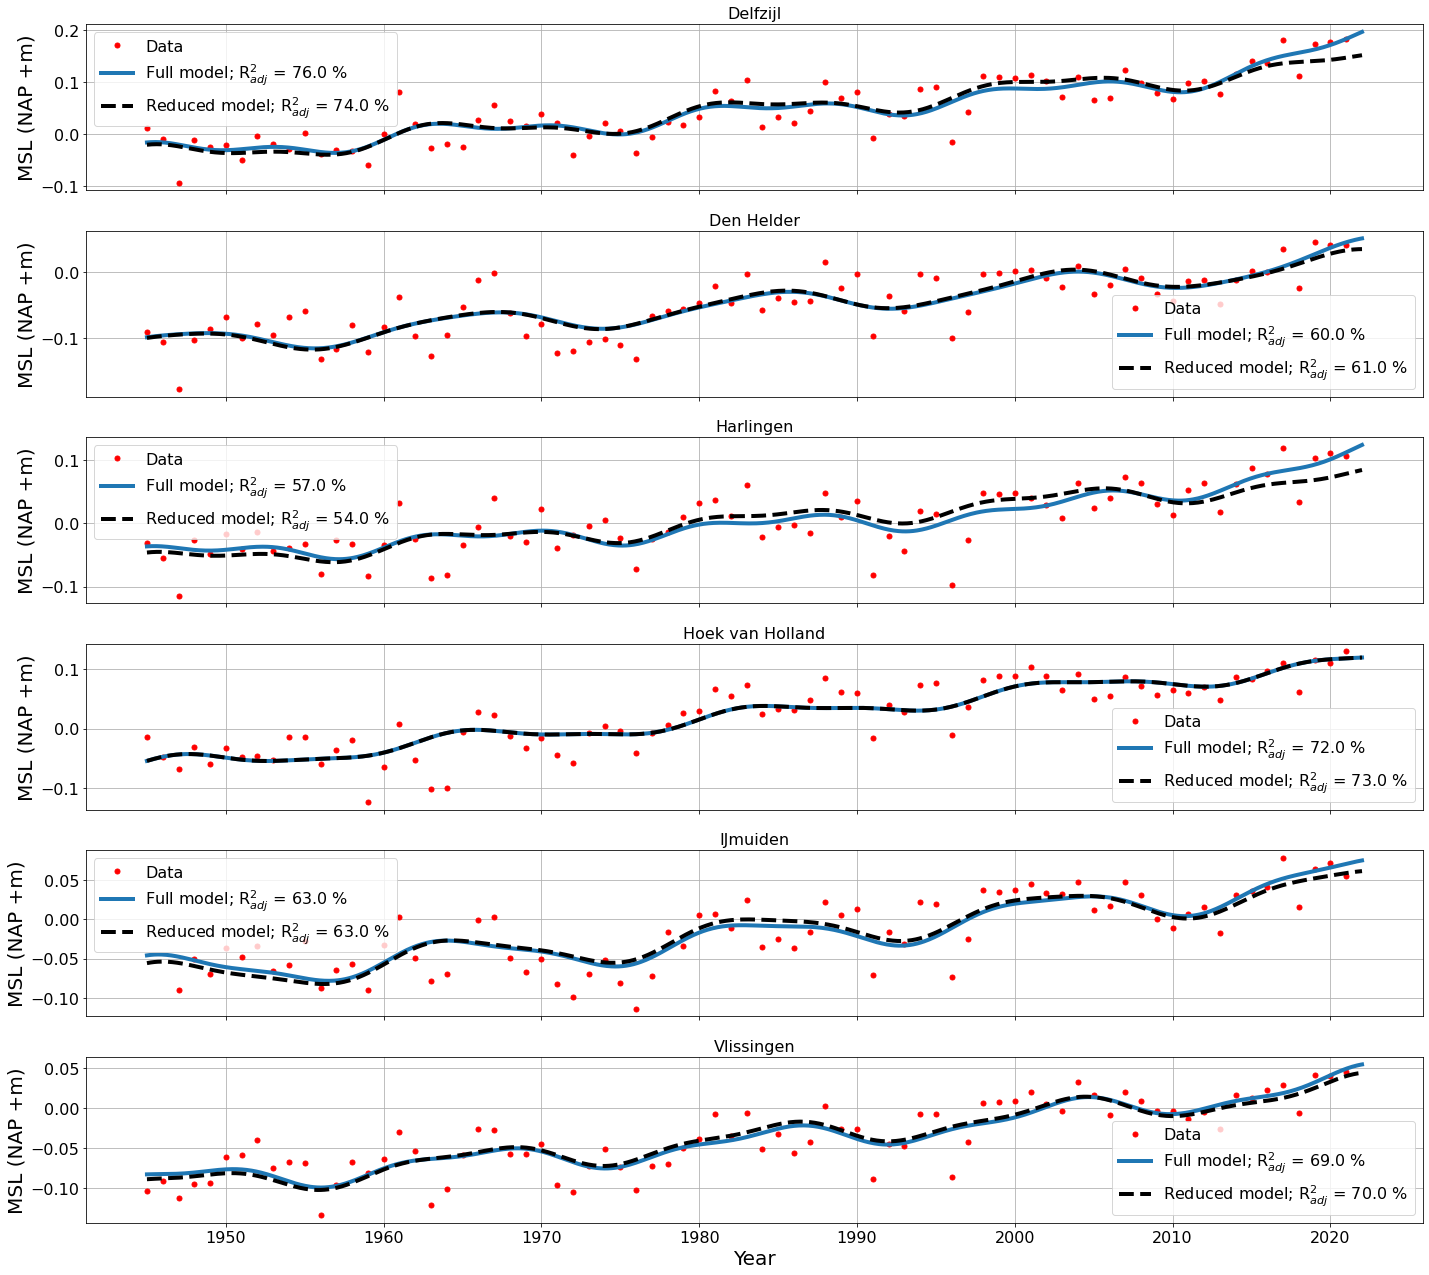

In [38]:
xgr = np.linspace(1945, 2022, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]

    plt.subplot(6,1,i+1)
    
    stplot.plot_data(
        data['year'], data['z0'], 'r.', label = 'Data',
        markersize = 10)
    
    stplot.plot_model(
        mdl.model6, data['year'], data['z0'], xgr,
        modelname = 'Full model', 
        bounds = (
            bnd_lo + [tprescr_lo - data['year'].mean()],
            bnd_up + [tprescr_up - data['year'].mean()]))
    
    stplot.plot_model(
        mdl.model3, data['year'], data['z0'], xgr, fmt = 'k--',
        modelname = 'Reduced model')
    
    plt.title(nm)
    plt.ylabel('MSL (NAP +m)')

    plt.legend()

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(r'../pics/z0_model6.jpg')
    

#### F-test of significance of climate signal

In [39]:
def Ftests_models_3_and_6(t, h):
    """
    Because of the bounds required to fit model 6, our normal procedures are not workable
    """
    ymodel3, k3 = sup.generate_model_data(mdl.model3, t, h)
    ymodel6, k6 = sup.generate_model_data(
        mdl.model6, t, h,
        method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - t.mean()],
            bnd_up + [tprescr_up - t.mean()])
            )

    res = gof.Ftest_red(ydata = h, ymodel_full = ymodel6, ymodel_red = ymodel3, kfull = k6, kred = k3)
    return pd.DataFrame(res, index = [0])


In [40]:
Fresult = df.groupby('naam').apply(
    lambda x: Ftests_models_3_and_6(x['year'], x['z0'])
)

In [41]:
Fresult.reset_index(inplace = True)
Fresult.drop(columns = 'level_1', inplace = True)

In [42]:
Fresult

,naam,F,p,alpha,Falpha,Test result
0,Delfzijl,2.034278e+00,0.117408,0.05,2.741574,True
1,Den Helder,1.718374e-01,0.915065,0.05,2.741574,True
2,Harlingen,2.657009e+00,0.055371,0.05,2.741574,True
3,Hoek van Holland,-4.351353e-09,1.000000,0.05,2.741574,True
4,IJmuiden,8.622652e-01,0.465344,0.05,2.748191,True
5,Vlissingen,7.211502e-01,0.542862,0.05,2.741574,True


#### End script
Prepared by HVEC lab, 2022